In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 22})

from grl.utils import load_info
from grl.utils.mdp import get_perf
from definitions import ROOT_DIR

In [2]:
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_pi')
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_pi_og')

# results_dir = Path(ROOT_DIR, 'results', 'tiger-alt-start_mi_pi_q_abs')
# results_dir = Path(ROOT_DIR, 'results', 'tiger-alt-start_mi_dm_q_abs')
results_dir = Path(ROOT_DIR, 'results', 'old', 'tiger-alt-start_mi_dm_q_abs(2 mi_iterations, 100k mi_steps)')

# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_dm')
vi_results_dir = Path(ROOT_DIR, 'results', 'pomdps_vi')
pomdp_files_dir = Path(ROOT_DIR, 'grl', 'environment', 'pomdp_files')

split_by = ['spec', 'algo', 'n_mem_states']
Args = namedtuple('args', split_by)
# this option allows us to compare to either the optimal belief state soln
# or optimal state soln. ('belief' | 'state')
compare_to = 'belief'

# spec_plot_order = ['example_7', 'slippery_tmaze_5_two_thirds_up',
#                    'tiger', 'paint.95', 'cheese.95',
#                    'network', 'shuttle.95', '4x3.95']
spec_plot_order = [
#     'example_7', 
    'tiger-alt-start'
]

spec_to_belief_state = {'tmaze_5_two_thirds_up': 'tmaze5'}

In [3]:
all_results = {}

for results_path in results_dir.iterdir():
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    info = load_info(results_path)

    args = info['args']
    if 'n_mem_states' not in args:
        args['n_mem_states'] = 2
    # agent = info['agent']
    init_policy_info = info['logs']['initial_policy_stats']
    init_improvement_info = info['logs']['greedy_initial_improvement_stats']
    final_mem_info = info['logs']['greedy_final_mem_stats']
    greedy_td_optimal_policy_stats = info['logs']['greedy_td_optimal_policy_stats']


    single_res = {
        'init_policy_perf': get_perf(init_policy_info),
#         'init_improvement_perf': get_perf(init_improvement_info),
        'init_improvement_perf': get_perf(greedy_td_optimal_policy_stats),
        'final_mem_perf': get_perf(final_mem_info),
        'init_policy': info['logs']['initial_policy'],
        'init_improvement_policy': info['logs']['initial_improvement_policy'],
        # 'final_mem': np.array(agent.memory),
        # 'final_policy': np.array(agent.policy)
    }

    hparams = Args(*tuple(args[s] for s in split_by))

    if hparams not in all_results:
        all_results[hparams] = {}

    for k, v in single_res.items():
        if k not in all_results[hparams]:
            all_results[hparams][k] = []
        all_results[hparams][k].append(v)
    all_results[hparams]['args'] = args

for hparams, res_dict in all_results.items():
    for k, v in res_dict.items():
        if k != 'args':
            all_results[hparams][k] = np.stack(v)

In [4]:
# results_path = Path(ROOT_DIR, 'results', 'tiger-alt-start_mi_pi(dm)_miit(2)_s(2023)_Sat Jan 21 11:41:13 2023.npy')
results_path = list(results_dir.iterdir())[-1]
agent_path = results_path.parent / 'agents' / f"{results_path.stem}.pkl.npy"
info = load_info(results_path)
agent = load_info(agent_path)

init_improvement_policy = info['logs']['initial_improvement_policy']
init_improvement_policy

array([[2.8284e-01, 4.0065e-01, 3.1650e-01],
       [5.8773e-01, 4.1227e-01, 1.3896e-07],
       [1.0000e+00, 4.5790e-07, 3.9510e-08],
       [9.9999e-01, 6.5812e-06, 6.5430e-06]])

In [5]:
def calc_lambda_discrep(stats: dict):
    v_diff_discrep = np.abs(stats['td_vals_v'] - stats['mc_vals_v']).mean()
    q_diff_discrep = np.abs(stats['td_vals_q'] - stats['mc_vals_q']).mean()
    return {'v_discrep': v_diff_discrep, 'q_discrep': q_diff_discrep}

init_improvement_stats = info['logs']['initial_improvement_stats']
greedy_init_improvement_stats = info['logs']['greedy_initial_improvement_stats']

td_optimal_policy_stats = info['logs']['td_optimal_policy_stats']
greedy_td_optimal_policy_stats = info['logs']['greedy_td_optimal_policy_stats']

final_mem_stats = info['logs']['final_mem_stats']
greedy_final_mem_stats = info['logs']['greedy_final_mem_stats']

# get_perf(init_improvement_stats), get_perf(final_mem_stats)
get_perf(greedy_td_optimal_policy_stats), get_perf(greedy_final_mem_stats), calc_lambda_discrep(final_mem_stats)

(-7.174999999999999,
 -1.8474502548598393,
 {'v_discrep': 0.45380196587980703, 'q_discrep': 0.35620424562337677})

In [14]:
greedy_final_mem_stats, final_mem_stats

({'v': array([1.5309e-18, 0.0000e+00, 1.3496e+01, 0.0000e+00, 3.1554e-30,
         5.9657e-03, 0.0000e+00, 0.0000e+00]),
  'q': array([[1.5309e-18, 0.0000e+00, 1.3496e+01, 2.6350e+01, 4.0644e-03,
          5.9657e-03, 1.2326e-32, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1554e-30,
          7.0997e-30, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 2.0195e-28, 0.0000e+00, 0.0000e+00,
          2.0195e-28, 0.0000e+00, 0.0000e+00]]),
  'mc_vals_q': array([[ -1.8475,   0.    ,   1.5687,   2.6335,   6.631 ,   4.7138,
           -1.    ,  -1.    ],
         [-45.    ,   0.    , -16.6646, -83.5794,   8.9147,  -6.5797,
            0.    ,   0.    ],
         [-45.    ,   0.    , -73.3354,  -6.4206, -98.9147, -83.4203,
            0.    ,   0.    ]]),
  'td_vals_q': array([[ -1.8475,   0.    ,   5.2423,  -2.4997,   6.5673,   4.6365,
           -1.    ,  -1.    ],
         [-45.    ,   0.    , -16.6646, -83.5794,   8.9147,  -6.5797,
            0.    ,

In [16]:
agent.memory, agent.policy

(DeviceArray([[[[9.9719e-07, 1.0000e+00],
                [4.0426e-01, 5.9574e-01]],
 
               [[5.8023e-01, 4.1977e-01],
                [9.2616e-07, 1.0000e+00]],
 
               [[1.0000e+00, 6.8763e-07],
                [9.9883e-01, 1.1668e-03]],
 
               [[3.8166e-01, 6.1834e-01],
                [7.2587e-01, 2.7413e-01]]],
 
 
              [[[6.2555e-01, 3.7445e-01],
                [5.2054e-01, 4.7946e-01]],
 
               [[7.0851e-01, 2.9149e-01],
                [3.8941e-01, 6.1059e-01]],
 
               [[4.0307e-01, 5.9693e-01],
                [5.0259e-01, 4.9741e-01]],
 
               [[6.5246e-01, 3.4754e-01],
                [5.4487e-01, 4.5513e-01]]],
 
 
              [[[6.2514e-01, 3.7486e-01],
                [5.5853e-01, 4.4147e-01]],
 
               [[5.4279e-01, 4.5721e-01],
                [4.1864e-01, 5.8136e-01]],
 
               [[7.3612e-01, 2.6388e-01],
                [7.8108e-01, 2.1892e-01]],
 
               [[2.0307e-01, 7.9693e-

In [17]:
if compare_to == 'belief':
    for fname in pomdp_files_dir.iterdir():
        if 'pomdp-solver-results' in fname.stem:
            for hparams in all_results.keys():
                if (fname.stem ==
                        f"{spec_to_belief_state.get(hparams.spec, hparams.spec)}-pomdp-solver-results"
                    ):
                    belief_info = load_info(fname)
                    coeffs = belief_info['coeffs']
                    max_start_vals = coeffs[belief_info['max_start_idx']]
                    all_results[hparams]['compare_perf'] = np.array(
                        [np.dot(max_start_vals, belief_info['p0'])])
                    # print(f"loaded results for {hparams.spec} from {fname}")

elif compare_to == 'state':
    for hparams, res_dict in all_results.items():
        for vi_path in vi_results_dir.iterdir():
            if hparams.spec in vi_path.name:
                vi_info = load_info(vi_path)
                all_results[hparams]['compare_perf'] = np.array([
                    (vi_info['optimal_vs'] * vi_info['p0']).sum()
                ])
else:
    raise NotImplementedError

In [18]:
list(all_results.values())[0]

{'init_policy_perf': array([-52.4978, -52.2354, -51.5068, -50.295 , -52.2378, -54.4271,
        -53.1488, -46.8697, -49.3594, -50.4529, -49.1381, -48.8586,
        -50.0219, -49.5627, -50.4812, -51.1004, -50.6628, -47.7137,
        -50.4953, -49.3584, -52.8769, -49.8966, -51.5698, -47.8228,
        -50.8433, -49.6393, -52.4657, -51.9119, -50.9637, -50.0235]),
 'init_improvement_perf': array([-7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175,
        -7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175,
        -7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175, -7.175,
        -7.175, -7.175, -7.175, -7.175, -7.175, -7.175]),
 'final_mem_perf': array([ -7.175 ,  -7.175 ,  -7.5399,  -7.54  ,  -1.8474,  -1.7827,
         -7.175 ,  -7.5402,  -7.5399,  -7.175 ,  -7.1751,  -7.175 ,
         -9.2015, -10.3617, -11.9383,  -9.7863,  -9.5748,  -7.5402,
         -1.8798, -11.5764,  -9.8554,  -1.7969,  -7.5399, -10.6936,
         -7.175 ,  -7.5399,  -7.175 ,  -7.175 ,  

In [19]:
for hparams, res in all_results.items():
    max_key = 'compare_perf'
    if max_key not in res:
        print(hparams)
    #     max_key = 'final_mem_perf'
    max_v = res[max_key]
    min_v = res['init_policy_perf'].min()
    for k, v in res.items():
        if '_perf' in k:
            all_results[hparams][k] = (v - min_v) / (max_v - min_v)

In [20]:
all_table_results = {}
all_plot_results = {'x': [], 'xlabels': []}

for i, spec in enumerate(spec_plot_order):
    hparams = sorted([k for k in all_results.keys() if k.spec == spec],
                     key=lambda hp: hp.n_mem_states)

    first_res = all_results[hparams[0]]
    all_plot_results['x'].append(i)
    all_plot_results['xlabels'].append(spec)

    # we first add initial and first improvement stats
    for k, v in first_res.items():
        if 'perf' in k and k != 'final_mem_perf':
            mean = v.max(axis=0)
            std_err = v.std(axis=0) / np.sqrt(v.shape[0])

            stripped_str = k.replace('_perf', '')
            if stripped_str not in all_plot_results:
                all_plot_results[stripped_str] = {'mean': [], 'std_err': []}
            all_plot_results[stripped_str]['mean'].append(mean)
            all_plot_results[stripped_str]['std_err'].append(std_err)

    # now we add final memory perf, for each n_mem_states
    for hparam in hparams:
        res = all_results[hparam]
        for k, v in res.items():
            if k == 'final_mem_perf':
                mean = v.max(axis=0)
                std_err = v.std(axis=0) / np.sqrt(v.shape[0])
                stripped_str = k.replace('_perf', '')
                mem_label = f"mem_{hparam.n_mem_states}"
                if mem_label not in all_plot_results:
                    all_plot_results[mem_label] = {'mean': [], 'std_err': []}
                all_plot_results[mem_label]['mean'].append(mean)
                all_plot_results[mem_label]['std_err'].append(std_err)

ordered_plot = []
# ordered_plot.append(('init_policy', all_plot_results['init_policy']))
ordered_plot.append(('init_improvement', all_plot_results['init_improvement']))
for k in sorted(all_plot_results.keys()):
    if 'mem' in k:
        ordered_plot.append((k, all_plot_results[k]))
# ordered_plot.append(('state_optimal', all_plot_results['vi']))


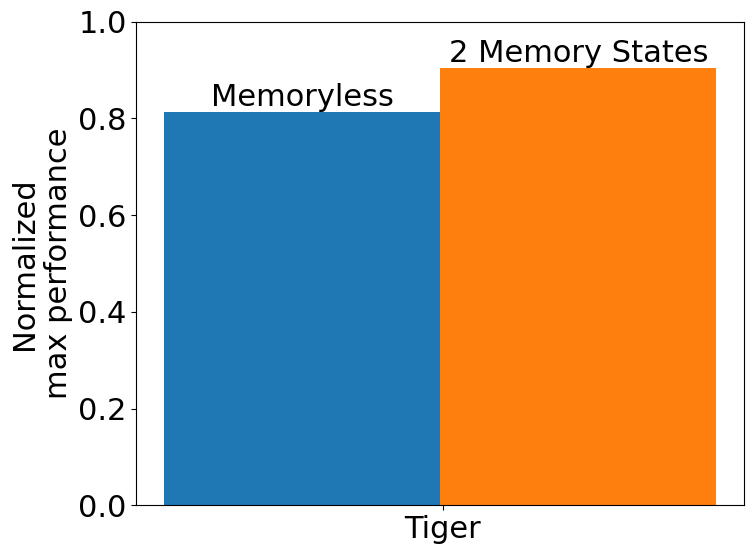

In [65]:
# filtered plots, where we only show n_mem_state = 2
def maybe_spec_map(id: str):
    spec_map = {
        '4x3.95': '4x3',
        'cheese.95': 'Cheese\nMaze',
        'paint.95': 'Paint',
        'shuttle.95': 'Shuttle',
        'example_7': 'ex. 7',
        'network': 'Network',
        'tmaze_5_two_thirds_up': 'T-maze',
        'tiger-alt-start': 'Tiger'
    }
    if id not in spec_map:
        return id
    return spec_map[id]

def label_map(label_str: str):
    if 'mem' in label_str:
        n_mem_states = int(label_str.split('_')[-1])
        return f"{n_mem_states} Memory States"
    elif label_str == 'init_improvement':
        return "Memoryless"

filtered_ordered_plot = []
    
for (label, v) in ordered_plot:
    if 'mem' in label:
        if int(label.split('_')[-1]) > 2:
            continue

    filtered_ordered_plot.append((label, v)) 
            
group_width = 1
bar_width = group_width / (len(filtered_ordered_plot) + 2)
fig, ax = plt.subplots(figsize=(8, 6))

x = np.array(all_plot_results['x'])
xlabels = [maybe_spec_map(l) for l in all_plot_results['xlabels']]
bars = []
bar_labels = []

for i, (label, plot_dict) in enumerate(filtered_ordered_plot):
    bars += ax.bar(x + (i + 1) * bar_width,
           plot_dict['mean'],
           bar_width,
#            yerr=plot_dict['std_err'],
           label=label_map(label))
    bar_labels.append(label_map(label))
    
for l, rect in zip(bar_labels, bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, l, ha='center', va='bottom')

ax.set_ylim([0, 1])
# ax.set_ylabel(f'Normalized Performance\n (w.r.t. optimal {compare_to} & random initial policy)')
ax.set_ylabel(f'Normalized\nmax performance')

ax.set_xticks(x + group_width / 2.65)
ax.set_xticklabels(xlabels)
fig.tight_layout()
# ax.legend(framealpha=0.95)
# ax.legend(loc='upper left', bbox_to_anchor=(0.3, 0.5), framealpha=0.95)


# ax.set_title("Performance of Memory Iteration in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}_max_2_mem.pdf"
fig.savefig(fig_path)

In [ ]:
# unfiltered, all n_mem_state
group_width = 1
bar_width = group_width / (len(ordered_plot) + 2)
fig, ax = plt.subplots(figsize=(12, 6))

x = np.array(all_plot_results['x'])
xlabels = [maybe_spec_map(l) for l in all_plot_results['xlabels']]

for i, (label, plot_dict) in enumerate(ordered_plot):
    ax.bar(x + (i + 1) * bar_width,
           plot_dict['mean'],
           bar_width,
           yerr=plot_dict['std_err'],
           label=label_map(label))
ax.set_ylim([0, 1])
# ax.set_ylabel(f'Normalized Performance\n (w.r.t. optimal {compare_to} & random initial policy)')
ax.set_ylabel(f'Normalized performance \n (10 runs)')

ax.set_xticks(x + group_width / 2.4)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(0.605, 1.02), framealpha=0.95)
fig.tight_layout()
# ax.set_title("Performance of Memory Iteration in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}_all.pdf"
fig.savefig(fig_path)